# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Scripts
import utils

pd.set_option("display.precision", 10)
pd.set_option("display.max_columns", 500)

%matplotlib inline

In [2]:
# Constants
DATA_PATH = "data/test"
MODEL_PATH = "models/" + DATA_PATH.split("/")[-1]

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data_reduced.csv", index_col=0)
df

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Power
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1048570,1048570,2021-01-13 03:16:10,0.0,0.0,0.0,0.0,0.0,0.0
1048571,1048571,2021-01-13 03:16:11,0.0,0.0,0.0,0.0,0.0,0.0
1048572,1048572,2021-01-13 03:16:12,0.0,0.0,0.0,0.0,0.0,0.0
1048573,1048573,2021-01-13 03:16:13,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

<AxesSubplot:>

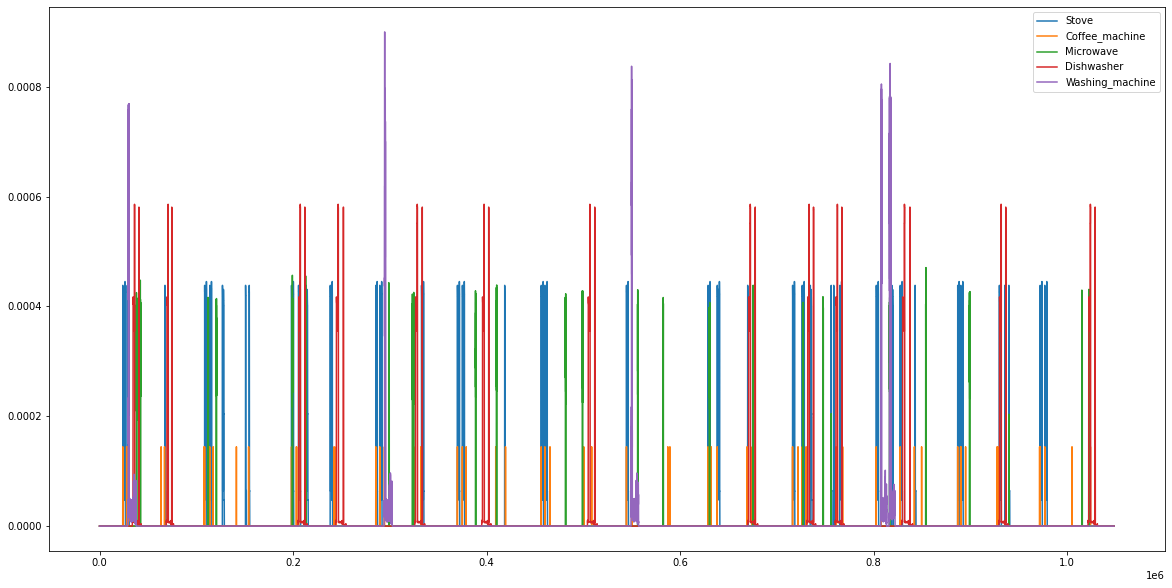

In [15]:
df.plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

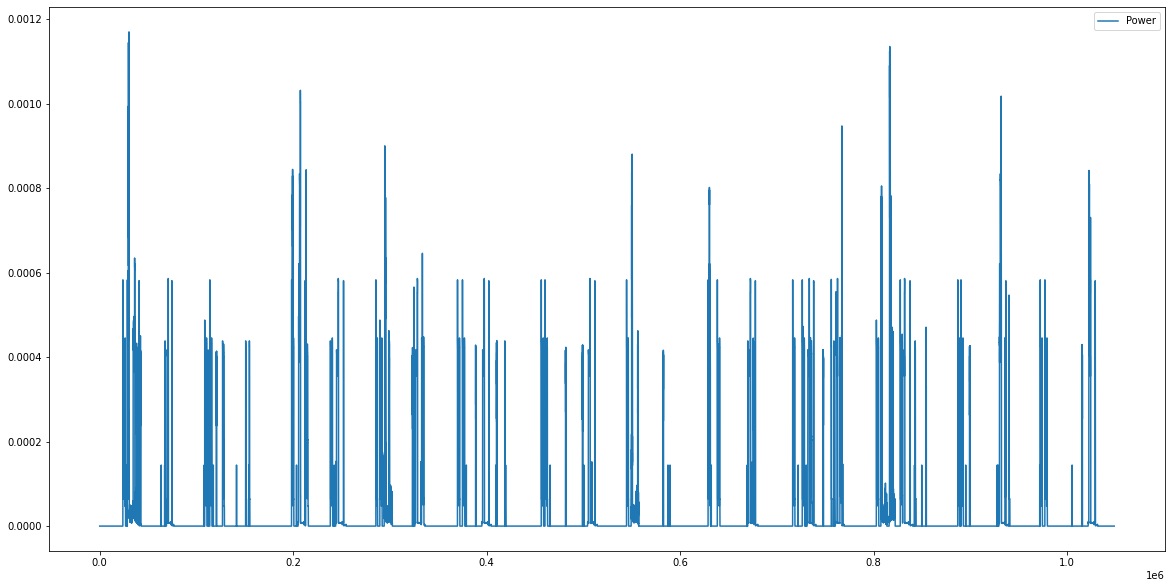

In [16]:
df.plot(y=["Power"], figsize=(20, 10))

<AxesSubplot:>

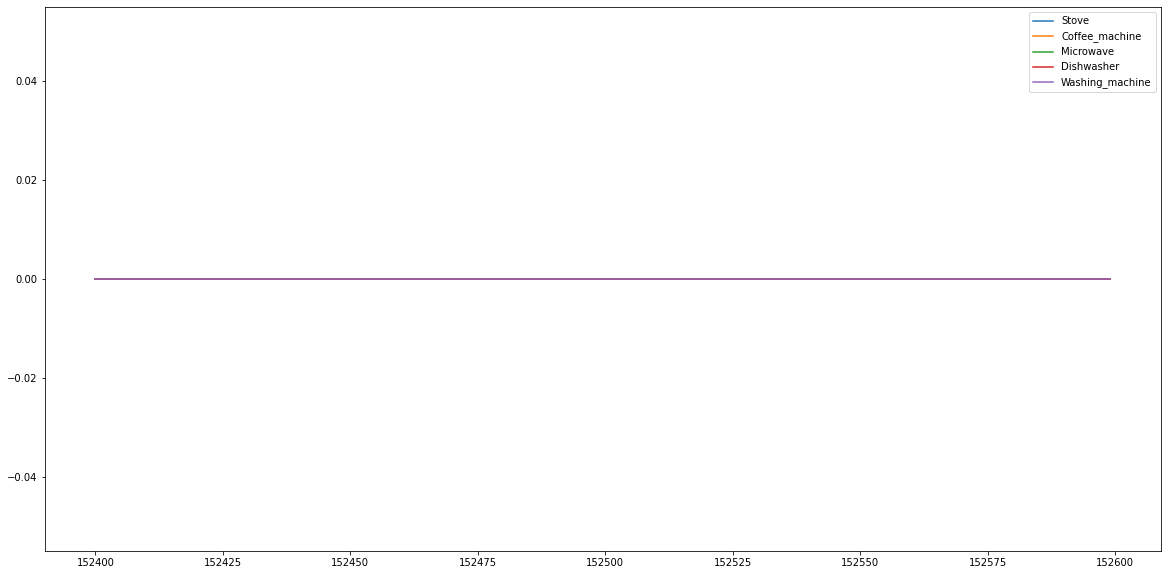

In [17]:
## microwave profile
df.iloc[152400:152600].plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

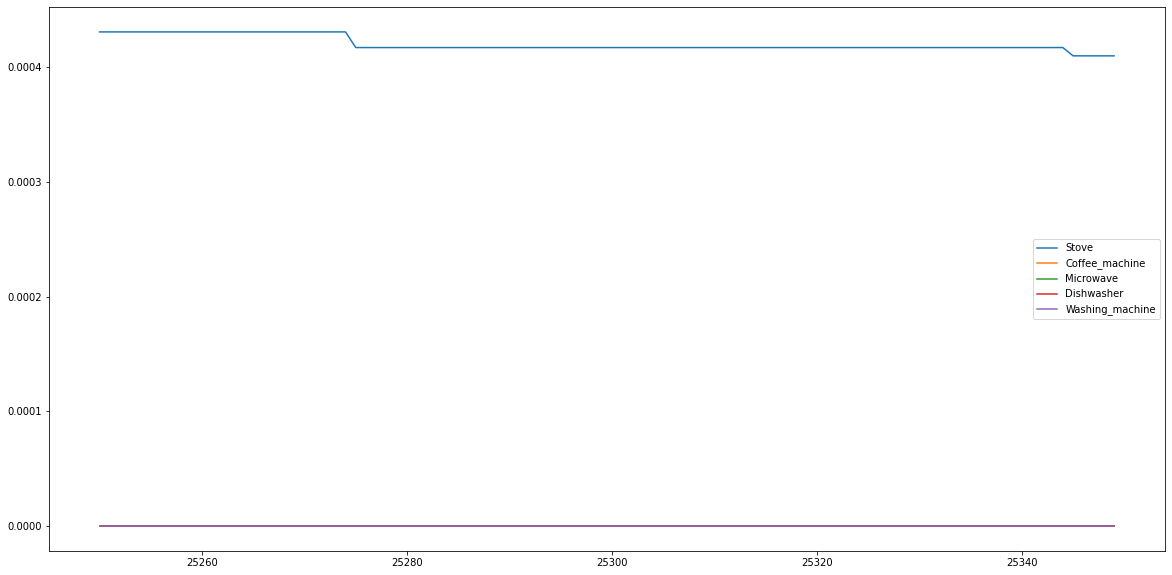

In [18]:
## why coffee machines dont work well
df.iloc[25250:25350].plot(y=appliances, figsize=(20, 10))

# Convert time series data to windowed data frame

In [5]:
window_size = 180
step = 1

In [6]:
windowed_data_path = f"{DATA_PATH}/windowed_{window_size}_step_{step}.csv"

In [ ]:
df_timeseries = utils.write_or_load_windows(
    windowed_data_path, df, window_size, step, appliances
)
df_timeseries

# Train-test split

In [21]:
samples = [x for i, x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True
)

# Modeling

In [24]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [25]:
X_train.shape

(175000, 180)

In [3]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import AveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential

In [123]:
EPOCHS = 100
BATCH_SIZE = 256

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, verbose=1, restore_best_weights=True
    ),
]

# Architecture insights
- Best model so far is true_DLO_doppelte_filter_60er_kernel_model with batch size 256, window size 180 with f1 scores between 88-96%, accuracy ~87% and LR at 5e-07
- GlobalMaxPooling seems to improve results on strongly imbalanced classes but worsens performance on "main" classes

In [276]:
from keras.layers import *


def create_model():
    kernel_size = 90

    input_layer = keras.layers.Input(shape=(window_size, 1))

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=kernel_size, padding="same")(
        input_layer
    )
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    max1 = keras.layers.MaxPool1D()(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=kernel_size, padding="same")(
        max1
    )
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    max2 = keras.layers.MaxPool1D()(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=kernel_size, padding="same")(
        max2
    )
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    max3 = keras.layers.MaxPool1D()(conv3)

    conv4 = keras.layers.Conv1D(filters=256, kernel_size=kernel_size, padding="same")(
        max3
    )
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)
    max4 = keras.layers.MaxPool1D()(conv4)

    conv5 = keras.layers.Conv1D(filters=512, kernel_size=kernel_size, padding="same")(
        max4
    )
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.ReLU()(conv5)

    gap = keras.layers.GlobalMaxPooling1D()(conv5)

    dense1 = keras.layers.Dense(512)(gap)
    dense1 = keras.layers.BatchNormalization()(dense1)
    dense1 = keras.layers.ReLU()(dense1)

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [277]:
LR = 0.0000006
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
f"Setting learning rate to {LR}"

'Setting learning rate to 6e-07'

In [278]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [279]:
model = create_model()

In [280]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["AUC", "binary_accuracy"])

In [281]:
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 1)]          0         
                                                                 
 conv1d_80 (Conv1D)          (None, 180, 128)          11648     
                                                                 
 re_lu_97 (ReLU)             (None, 180, 128)          0         
                                                                 
 batch_normalization_97 (Bat  (None, 180, 128)         512       
 chNormalization)                                                
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 90, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_81 (Conv1D)          (None, 90, 128)           147

In [282]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
)

Epoch 1/100
684/684 [==============================] - 52s 74ms/step - loss: 0.3550 - auc: 0.9299 - binary_accuracy: 0.8869 - val_loss: 1.1961 - val_auc: 0.3739 - val_binary_accuracy: 0.3627 - lr: 6.0000e-07
Epoch 2/100
684/684 [==============================] - 51s 75ms/step - loss: 0.2411 - auc: 0.9616 - binary_accuracy: 0.9352 - val_loss: 0.2266 - val_auc: 0.9645 - val_binary_accuracy: 0.9420 - lr: 6.0000e-07
Epoch 3/100
684/684 [==============================] - 51s 74ms/step - loss: 0.2080 - auc: 0.9707 - binary_accuracy: 0.9437 - val_loss: 0.2026 - val_auc: 0.9721 - val_binary_accuracy: 0.9473 - lr: 6.0000e-07
Epoch 4/100
684/684 [==============================] - 51s 75ms/step - loss: 0.1870 - auc: 0.9762 - binary_accuracy: 0.9489 - val_loss: 0.1812 - val_auc: 0.9792 - val_binary_accuracy: 0.9528 - lr: 6.0000e-07
Epoch 5/100
684/684 [==============================] - 51s 75ms/step - loss: 0.1723 - auc: 0.9798 - binary_accuracy: 0.9520 - val_loss: 0.1707 - val_auc: 0.9790 - val_b

In [283]:
df_prediction = pd.DataFrame(model.predict(X_test))
df_prediction

,0,1,2,3,4
0,0.0052076606,0.0060271830,0.0061573652,0.9953041077,0.0059109093
1,0.0040042070,0.0048969546,0.0077514611,0.0617310815,0.9967279434
2,0.0046093729,0.0056279800,0.0057789339,0.9972385168,0.0030338950
3,0.0034371449,0.0060830144,0.0059514074,0.0184397604,0.9990642667
4,0.0986134857,0.0105711678,0.0119538754,0.9442257285,0.2230628133
...,...,...,...,...,...
51466,0.0169300102,0.0101714917,0.0071513532,0.7871870399,0.2080804855
51467,0.0049472088,0.0059132068,0.0060890634,0.9958836436,0.0053059980
51468,0.0024136237,0.0052855588,0.9997661710,0.0911138281,0.0118835131
51469,0.6625257134,0.0081292242,0.3991251588,0.0167451426,0.0009581051


In [284]:
THRESHOLD = 0.5
y_pred = model.predict(X_test)
y_pred[y_pred >= THRESHOLD] = 1
y_pred[y_pred < THRESHOLD] = 0
y_pred

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [285]:
test_loss, test_auc, test_acc = model.evaluate(X_test, y_test)

print("Test AUC", test_auc)
print("Test Acc", test_acc)
print("Test loss", test_loss)

1609/1609 [==============================] - 16s 10ms/step - loss: 0.0480 - auc: 0.9982 - binary_accuracy: 0.9847
Test AUC 0.9982198476791382
Test Acc 0.9847246408462524
Test loss 0.04795588180422783


In [286]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9330496784597152

In [288]:
MODEL_NAME = "DLO_128,128,128,256,512_90er_kernel_GlobalMaxPool_model"

In [289]:
model.save(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")

INFO:tensorflow:Assets written to: models/test/DLO_128,128,128,256,512_90er_kernel_GlobalMaxPool_model/LR=6e-07,Epochs=100,BATCH=256\assets


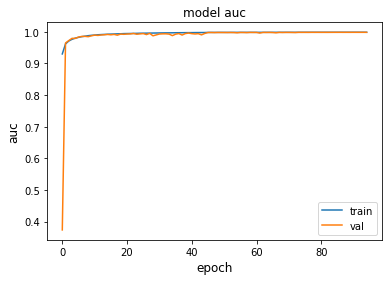

In [290]:
metric = "auc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.savefig(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")
plt.show()
plt.close()

In [291]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

print(
    classification_report(y_test, y_pred, target_names=appliances, zero_division=False)
)

                 precision    recall  f1-score   support

          Stove       0.99      0.99      0.99     18565
 Coffee_machine       0.96      0.95      0.95      3135
      Microwave       0.98      0.94      0.96      3834
     Dishwasher       0.99      0.91      0.95     25408
Washing_machine       1.00      0.95      0.97      9381

      micro avg       0.99      0.95      0.97     60323
      macro avg       0.98      0.95      0.97     60323
   weighted avg       0.99      0.95      0.97     60323
    samples avg       0.99      0.97      0.97     60323



Accuracy: 0.9925394882555225


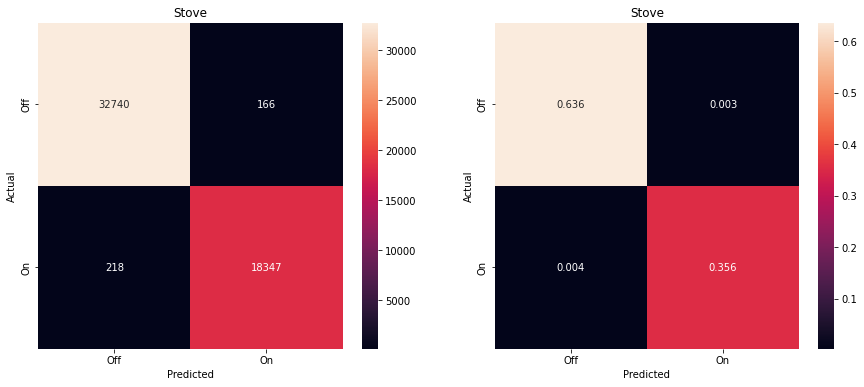

Accuracy: 0.9945211866876493


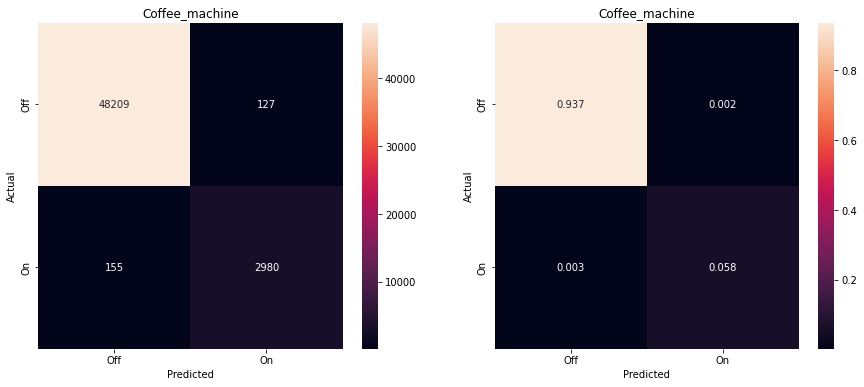

Accuracy: 0.9945600435196519


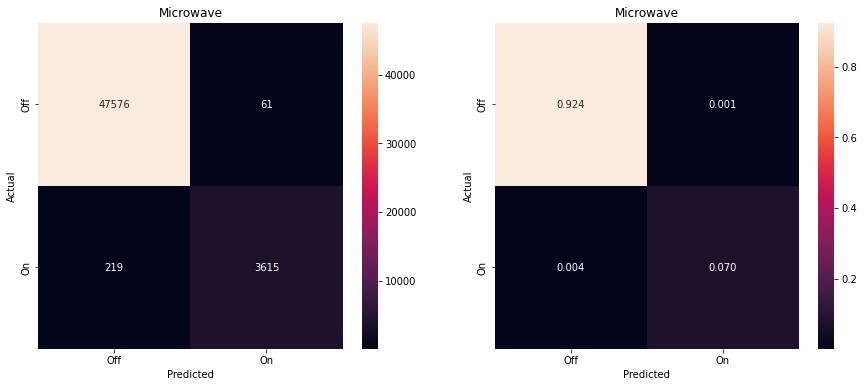

Accuracy: 0.9521283829729362


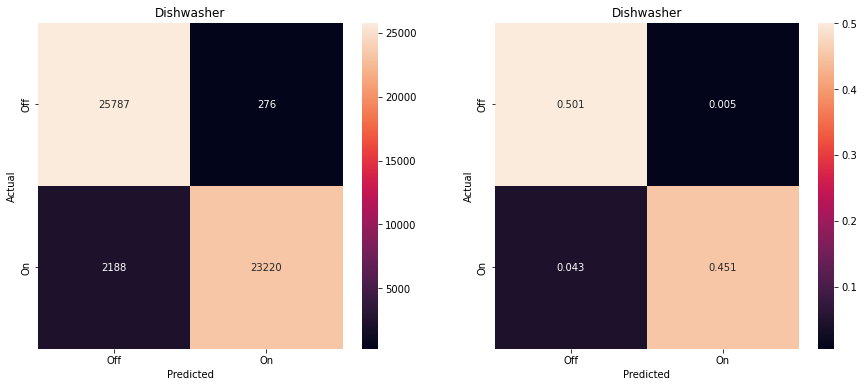

Accuracy: 0.989858366847351


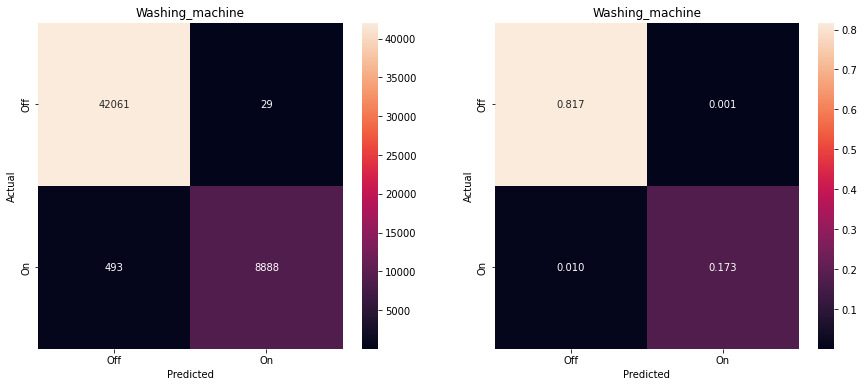

In [292]:
columns = ["Off", "On"]
for idx, item in enumerate(mcm):
    tn, fp, fn, tp = item.ravel()
    print(f"Accuracy: {(tp+tn)/(tn+fp+fn+tp)}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    heat = sns.heatmap(
        item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1
    )
    norm_item = item.astype("float") / item.sum(axis=None)
    norm_heat = sns.heatmap(
        norm_item,
        annot=True,
        fmt=".3f",
        xticklabels=columns,
        yticklabels=columns,
        ax=ax2,
    )
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()